In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [2]:
torch.manual_seed(1)
output_path = "/content/drive/MyDrive/CPSC-8430-Deep-Learning-001/HW1/1.2/"

# Loading MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

mnist_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [4]:
def create_train_loader(batch_size):
    return torch.utils.data.DataLoader(dataset=mnist_train, 
                                       batch_size=batch_size, 
                                       shuffle=True)

def create_test_loader(batch_size):
    return torch.utils.data.DataLoader(dataset=mnist_test, 
                                       batch_size=batch_size, 
                                       shuffle=False)

print("Training dataset size:", len(mnist_train), "\nTesting dataset size:", len(mnist_test))


Training dataset size: 60000 
Testing dataset size: 10000


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 50)
        self.layer3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
# Training the function
def execute_training(model, epochs, batch_size, log_interval):
    model.train()
    print('Training started')
    train_loader = create_train_loader(batch_size)
    total_steps = len(train_loader)
    losses = []
    epoch_counts = []
    accuracies = []
    epoch_stats = []
    loss_avg_array = []
    accuracy_avg_array = []
    weight_data = pd.DataFrame()

    for epoch in range(epochs):
        epoch += 1
        correct_predictions = 0
        total_samples = 0
        loss_sum = 0
        epoch_accuracy = 0
        epoch_record = pd.DataFrame()

        for step, (images, labels) in enumerate(train_loader):
            images, labels = Variable(images), Variable(labels)
            optimizer.zero_grad()

            # Forward pass
            predictions = model(images)

            loss = loss_function(predictions, labels)
            loss_sum += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            _, predicted_classes = torch.max(predictions.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()
            accuracy = 100.0 * correct_predictions / total_samples
            epoch_accuracy += accuracy

            losses.append(loss.item())
            accuracies.append(accuracy)
            epoch_counts.append(epoch)

            # Logging status
            if (step + 1) % log_interval == 0:
                print(f'Training Progress: Epoch [{epoch}/{epochs}], Step [{step + 1}/{total_steps}], Loss: {loss.item():.4f}', end='\r', flush=True)

        # Collecting the weights
        for name, param in model.named_parameters():
            if 'weight' in name:
                weight_vector = parameters_to_vector(param).detach().numpy() 
                epoch_record = pd.concat([epoch_record, pd.DataFrame(weight_vector).T], axis=1) 

        weight_data = pd.concat([weight_data, epoch_record], axis=0)

        avg_loss = loss_sum / total_steps
        avg_accuracy = epoch_accuracy / total_steps
        loss_avg_array.append(avg_loss)    
        accuracy_avg_array.append(avg_accuracy)

    return epoch_counts, losses, accuracies, loss_avg_array, accuracy_avg_array, weight_data

In [7]:
def evaluate_model(model, loss_func, batch_size): 
    test_loader = create_test_loader(batch_size)
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_samples = 0
        total_loss = 0
        count = 0
        for images, labels in test_loader:
            images, labels = Variable(images), Variable(labels)

            predictions = model(images)
            total_loss += loss_func(predictions, labels).item()
            _, predicted_classes = torch.max(predictions.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()
            count += 1
            
    avg_test_loss = total_loss / count
    test_accuracy = 100.0 * correct_predictions / total_samples
    print(f'Accuracy on test set: {test_accuracy}% & Test Loss: {avg_test_loss}', end='\r', flush=True)
    return test_accuracy, avg_test_loss


In [8]:
parameter_counts = []
temp_model = NeuralNetwork()
for param in temp_model.parameters():
    parameter_counts.append(torch.numel(param))
print(f'Total number of parameters: {np.sum(parameter_counts)}')


Total number of parameters: 418060


In [12]:
max_epochs = 45
combined_df = pd.DataFrame()
train_accuracy_dict = {}
test_accuracy_dict = {}
train_loss_dict = {}
test_loss_dict = {}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_function = nn.CrossEntropyLoss()

for iteration in range(8):
    current_model = NeuralNetwork()

    print("Iteration: " + str(iteration))
    optimizer = torch.optim.Adam(current_model.parameters(), lr=0.0004, weight_decay=1e-4)
    
    epoch_counts, losses, accuracies, loss_avg, accuracy_avg, weight_data = execute_training(current_model, max_epochs, train_batch_size, status_interval)
    test_accuracy, test_loss = evaluate_model(current_model, loss_function, test_batch_size)

    combined_df = pd.concat([combined_df, weight_data], ignore_index=True)
    
    test_accuracy_dict[iteration] = test_accuracy
    train_loss_dict[iteration] = loss_avg
    test_loss_dict[iteration] = test_loss
    train_accuracy_dict[iteration] = accuracy_avg

# Collecting training accuracy and loss into arrays
train_accuracy_array = [train_accuracy_dict[key] for key in range(8)]
train_loss_array = [train_loss_dict[key] for key in range(8)]

# Converting arrays to DataFrames and then flatten them
train_accuracy_df = pd.DataFrame(train_accuracy_array)
train_accuracy_data = train_accuracy_df.values.flatten()

train_loss_df = pd.DataFrame(train_loss_array)
train_loss_data = train_loss_df.values.flatten()

print(combined_df)
print(f'Shape of Loss: {train_loss_data.shape} & Shape of Accuracy: {train_accuracy_data.shape}')


Iteration: 0
Training started
Iteration: 1test set: 97.99% & Test Loss: 0.06356273544952273
Training started
Iteration: 2test set: 98.08% & Test Loss: 0.06228940179571509
Training started
Iteration: 3test set: 97.96% & Test Loss: 0.06417810041457414
Training started
Iteration: 4test set: 98.11% & Test Loss: 0.0639343949034815
Training started
Iteration: 5test set: 98.09% & Test Loss: 0.06616341462358832
Training started
Iteration: 6test set: 97.99% & Test Loss: 0.06383200250566005
Training started
Iteration: 7test set: 98.05% & Test Loss: 0.06325912363827228
Training started
              0             1             2             3             4    \
0    5.828640e-04  1.351724e-02 -9.909965e-05 -1.102045e-02  3.446586e-05   
1   -1.974606e-05  3.024578e-03  1.798697e-06 -1.841009e-03 -2.503370e-06   
2   -1.401441e-06  3.194515e-04  4.282232e-07 -9.468146e-05 -6.432990e-08   
3   -6.171597e-08  7.877534e-06  1.708830e-08  2.906166e-06  5.681259e-09   
4   -2.118604e-09 -5.298666e-07  

            x         y  Epoch  Iteration   Accuracy      Loss
0    1.917085 -0.855272      0          0  56.498083  1.310404
1    2.366522 -1.061569      1          0  88.336726  0.401011
2    2.648352 -1.184905      2          0  91.013034  0.299849
3    2.888440 -1.280784      3          0  92.715402  0.253752
4    3.110455 -1.372744      4          0  93.647910  0.221683
..        ...       ...    ...        ...        ...       ...
355  7.457774 -8.602939     40          7  99.746136  0.018803
356  7.437284 -8.579176     41          7  99.748783  0.017712
357  7.419097 -8.558180     42          7  99.795154  0.016639
358  7.395178 -8.533713     43          7  99.806904  0.015861
359  7.369401 -8.507633     44          7  99.822704  0.015440

[360 rows x 6 columns]
            x         y  Epoch  Iteration   Accuracy      Loss
0    2.648352 -1.184905      2          0  91.013034  0.299849
1    3.297696 -1.451580      5          0  94.333344  0.195114
2    3.753456 -1.632167      8 

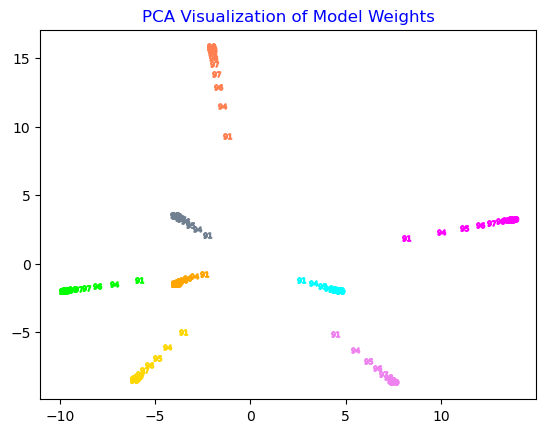

<Figure size 5000x2500 with 0 Axes>

In [17]:
def perform_pca(param_df, iteration):
    pca_model = PCA(n_components=2)
    pca_results = pca_model.fit_transform(param_df)
    iteration_data = np.full((pca_results.shape[0], 1), iteration)
    pca_dataframe = pd.DataFrame(np.hstack((pca_results, iteration_data)), columns=['x', 'y', 'Iteration'])
    return pca_dataframe

# Below we are converting combined DataFrame to numpy array
combined_data = np.array(combined_df)

# Perform PCA
pca_model = PCA(n_components=2)
transformed_data = pca_model.fit_transform(combined_data)

# Creating DataFrame with PCA results
all_epochs_df = pd.DataFrame(transformed_data, columns=['x', 'y'])

# Creating epoch and iterating the columns
epoch_indices = [i for i in range(max_epochs)] * 8
iteration_numbers = np.repeat([i for i in range(8)], max_epochs)

# Adding new columns to DataFrame
all_epochs_df['Epoch'] = epoch_indices
all_epochs_df['Iteration'] = iteration_numbers
all_epochs_df['Accuracy'] = train_accuracy_data
all_epochs_df['Loss'] = train_loss_data

print(all_epochs_df)

# Filtering the DataFrame for specific epochs
filtered_epoch_df = all_epochs_df.loc[(all_epochs_df['Epoch'] + 1) % 3 == 0].reset_index(drop=True)
print(filtered_epoch_df)


accuracy_values = np.array(filtered_epoch_df['Accuracy'])
marker_values = [str(int(acc)) for acc in accuracy_values]
colors = ['cyan', 'magenta', 'lime', 'coral', 'gold', 'slategray', 'orange', 'violet']

for index in range(len(marker_values)):
    marker = marker_values[index]
    iteration_index = filtered_epoch_df['Iteration'][index]
    plt.scatter(filtered_epoch_df['x'][index], filtered_epoch_df['y'][index], marker=f'${marker}$', color=colors[iteration_index])

plt.title("PCA Visualization of Model Weights", color="blue")
plt.figure(figsize=[10, 5], dpi=500)

plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [20]:
torch.manual_seed(1)

# Generating the data
input_data = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)
output_data = (np.sin(5 * np.pi * input_data.numpy()) / (5 * np.pi * input_data.numpy()))
output_data[output_data == np.inf] = 1  # Replace infinities with 1
print('Input shape:', input_data.shape, "\nOutput shape:", output_data.shape)

Input shape: torch.Size([300, 1]) 
Output shape: (300, 1)


In [21]:
# Converting to tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)
num_samples, num_features = input_tensor.shape

/local_scratch/slurm.711896/ipykernel_1668994/1793714632.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_data, dtype=torch.float32)


In [22]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(1, 500)
        self.layer2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [23]:
def train_model(model, x, y):
    max_epochs = 2500
    epoch_list, loss_list = [], []
    convergence = True
    epoch_counter = 0
    gradient_norms = []
    
    while convergence:
        epoch_counter += 1
        predictions = model(x)
        loss = loss_function(predictions, y)
        
        optimizer.zero_grad()
        loss.backward()
        loss_value = loss.item()

        epoch_list.append(epoch_counter)
        loss_list.append(loss_value)

        total_gradient = 0.0
        for param in model.parameters():
            if param.grad is not None:
                total_gradient += (param.grad.data.numpy() ** 2).sum()
        gradient_norm = total_gradient ** 0.5

        optimizer.step()
        gradient_norms.append(gradient_norm)

        if epoch_counter % 100 == 0:
            print(f'Epoch: {epoch_counter}, Loss = {loss_value:.4f}, Gradient Norm = {gradient_norm:.4f}')

        if epoch_counter == max_epochs:
            print("Maximum Epoch Limit Reached")
            convergence = False
        elif (epoch_counter > 5) and (loss_value < 0.001):
            if abs(loss_list[-3] - loss_list[-2]) < 1.0e-5 and abs(loss_list[-2] - loss_list[-1]) < 1.0e-5:
                print("Convergence reached with loss:", loss_value)
                convergence = False

    return epoch_list, loss_list, predictions, gradient_norm, gradient_norms

In [24]:
torch.manual_seed(1)
neural_net = NeuralNet()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=1e-3, weight_decay=1e-4)
loss_function = nn.MSELoss()  # Mean Squared Error for regression

parameter_count = [torch.numel(param) for param in neural_net.parameters()]
print('Total parameters in NeuralNet:', np.sum(parameter_count))

Total parameters in NeuralNet: 1501


Convergence reached with loss: 0.0009953775443136692


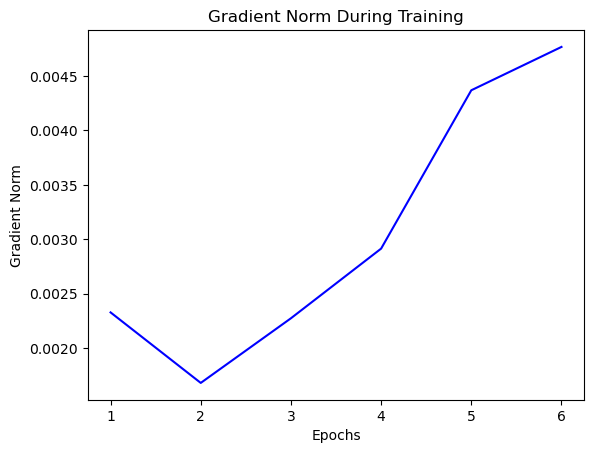

In [26]:
# Training the model
epochs, losses, final_predictions, final_gradient_norm, gradient_list = train_model(neural_net, input_tensor, output_tensor)

plt.plot(epochs, gradient_list, color="blue")
plt.title('Gradient Norm During Training')
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.show()

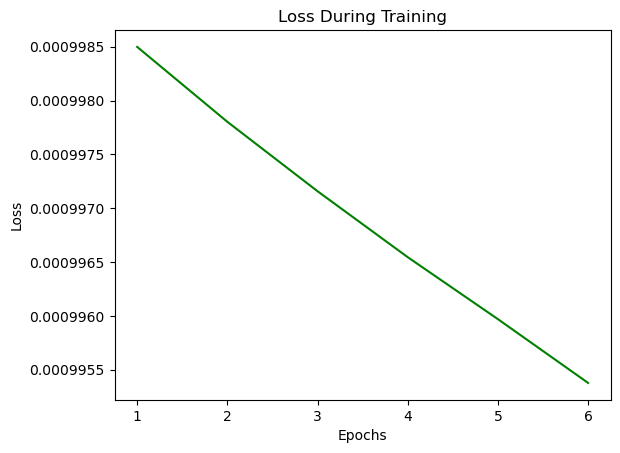

In [27]:
# Plotting Loss
plt.plot(epochs, losses, color="green")
plt.title('Loss During Training')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

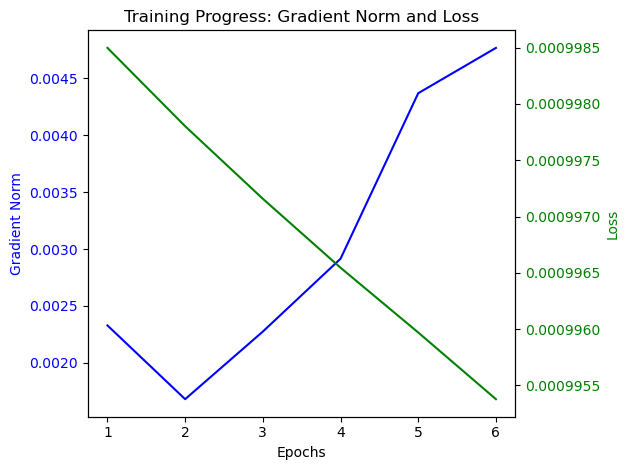

In [42]:
fig, ax1 = plt.subplots()

# Plot gradient norm on the first y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Gradient Norm', color='blue')
ax1.plot(epochs, gradient_list, color='blue', label='Gradient Norm')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='green')
ax2.plot(epochs, losses, color='green', label='Loss')
ax2.tick_params(axis='y', labelcolor='green')

# Add titles and legends
plt.title('Training Progress: Gradient Norm and Loss')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict


In [30]:
torch.manual_seed(1)

# Generate synthetic data
def generate_data(num_samples=300):
    x = torch.unsqueeze(torch.linspace(-1, 1, num_samples), dim=1)
    y = (torch.sin(5 * np.pi * x) / (5 * np.pi * x)).clone()
    y[y == float('inf')] = 1  # Handle infinities
    return x, y

X_data, Y_data = generate_data()
dataset = TensorDataset(X_data, Y_data)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [33]:
class RegressionModel(nn.Module):
    def __init__(self, hidden_units=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.network(x)
    
    def training_step(self, batch, loss_function):
        inputs, targets = batch 
        predictions = self(inputs)
        loss = loss_function(predictions, targets)
        return loss
    
    def validation_step(self, batch, loss_function):
        inputs, targets = batch 
        predictions = self(inputs)
        loss = loss_function(predictions, targets)
        return {'validation_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'validation_loss': epoch_loss.item()}
    
    def train_step(self, batch, loss_function):
        inputs, targets = batch 
        predictions = self(inputs)
        loss = loss_function(predictions, targets)
        return {'training_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['training_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'training_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], Validation Loss: {result['validation_loss']:.4f}")


In [34]:
def compute_gradients_and_ratios(model, criterion, train_data, target_data):
    model.train()
    model.zero_grad()
    output = model(train_data)
    loss = criterion(output, target_data)
    loss.backward()

    gradients = [p.weight.grad.norm(2).item() for p in model.network if isinstance(p, nn.Linear)]
    gradient_mean = np.mean(gradients)
    
    return gradient_mean

In [35]:
def evaluate_model(model, loss_function, data_loader):
    outputs = [model.validation_step(batch, loss_function) for batch in data_loader]
    return model.validation_epoch_end(outputs)


In [36]:
def fit_model(epochs, learning_rate, model, data_loader, criterion, optimizer_func):
    history = []
    grad_norms = {}
    
    optimizer = optimizer_func(model.parameters(), learning_rate)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        predictions = model(X_data)
        loss = criterion(predictions, Y_data)
        loss.backward()
        
        grad_norms[epoch] = compute_gradients_and_ratios(model, criterion, X_data, Y_data)
        optimizer.step()
        
        result = evaluate_model(model, criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history, grad_norms, model


In [37]:
# Parameters
num_samples = 300
learning_rate = 0.0004
num_epochs = 2500
loss_function = nn.MSELoss()
optimizer_function = torch.optim.Adam

# Initializing the Model
regression_model = RegressionModel()

initial_result = evaluate_model(regression_model, loss_function, data_loader)

training_history, gradients_history, trained_model = fit_model(num_epochs, learning_rate, regression_model, data_loader, loss_function, optimizer_function)

# Extracting validation losses
validation_losses = [result['validation_loss'] for result in training_history]

minimal_ratios = [gradients_history[epoch] for epoch in range(num_epochs)]

Epoch [0], Validation Loss: 0.1534
Epoch [1], Validation Loss: 0.1475
Epoch [2], Validation Loss: 0.1420
Epoch [3], Validation Loss: 0.1370
Epoch [4], Validation Loss: 0.1325
Epoch [5], Validation Loss: 0.1283
Epoch [6], Validation Loss: 0.1245
Epoch [7], Validation Loss: 0.1210
Epoch [8], Validation Loss: 0.1179
Epoch [9], Validation Loss: 0.1151
Epoch [10], Validation Loss: 0.1125
Epoch [11], Validation Loss: 0.1101
Epoch [12], Validation Loss: 0.1079
Epoch [13], Validation Loss: 0.1059
Epoch [14], Validation Loss: 0.1041
Epoch [15], Validation Loss: 0.1024
Epoch [16], Validation Loss: 0.1007
Epoch [17], Validation Loss: 0.0992
Epoch [18], Validation Loss: 0.0978
Epoch [19], Validation Loss: 0.0964
Epoch [20], Validation Loss: 0.0952
Epoch [21], Validation Loss: 0.0940
Epoch [22], Validation Loss: 0.0928
Epoch [23], Validation Loss: 0.0917
Epoch [24], Validation Loss: 0.0907
Epoch [25], Validation Loss: 0.0898
Epoch [26], Validation Loss: 0.0889
Epoch [27], Validation Loss: 0.0881
Ep

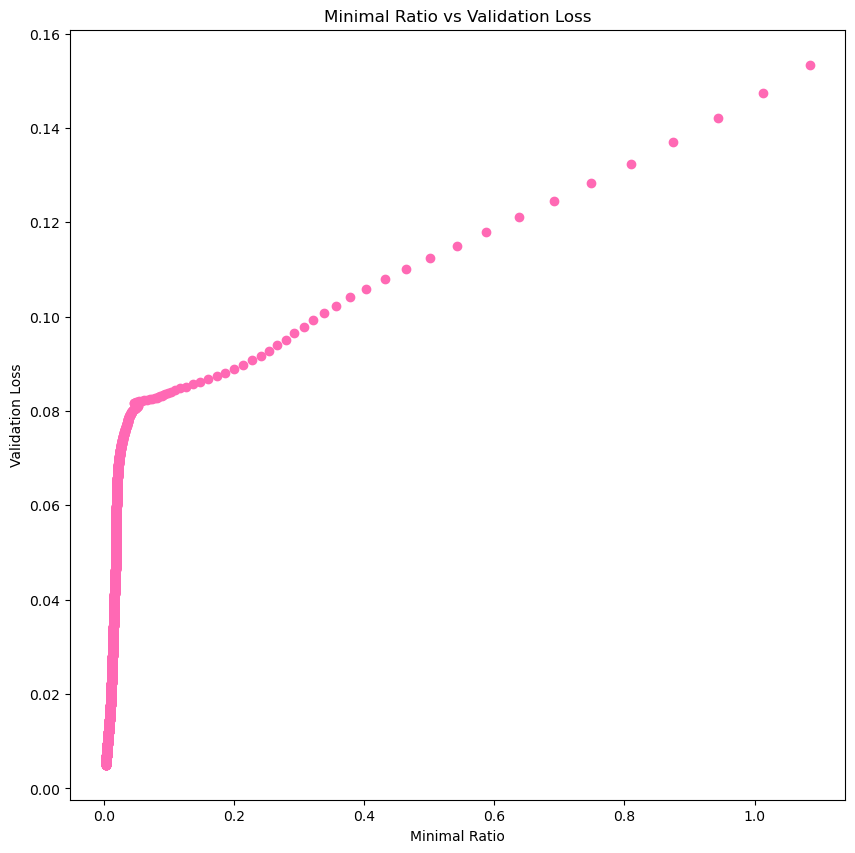

In [41]:
# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(minimal_ratios, validation_losses, color='hotpink')
plt.xlabel('Minimal Ratio')
plt.ylabel('Validation Loss')
plt.title('Minimal Ratio vs Validation Loss')
plt.show()